# Weaviate Challenge Solution
## William Pugsley

We will explore the [LinkedIn job postings (2023-2024) dataset](https://www.kaggle.com/datasets/arshkon/linkedin-job-postings/) from Kaggle. The purpose of this project is to cluster job postings in the machine learning field.

Requires the postings.csv file from Kaggle to be in the directory.



Explore data

Engineer data (salaries, no descriptions, etc.)

Add files to Weaviate server

Find jobs closest to data science, machine learning, AI

plot scatter plots of salary vs. views, views vs. applies, 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
import os
import weaviate
import weaviate.classes as wvc
from scipy.stats import linregress
from sklearn.preprocessing import LabelEncoder

# Preliminaries

In [2]:
#reads a file that holds all the API keys and URLs

# open the file in read mode
with open("secrets.txt", 'r') as file:
    # read lines from the file
    lines = file.readlines()

secrets = {}

# iterate through each line and split key-value pairs
for line in lines:
    key, value = line.strip().split(',')
    secrets[key.strip()] = value.strip()

# Data Exploration

We will start by exploring the dataset, extracting the relevant instances, and engineering new fields.

In [3]:
df_postings_raw = pd.read_csv("postings.csv")

In [4]:
df_postings_raw.head(2)

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,1.715990e+12,NaN,NaN,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,1.715450e+12,NaN,NaN,NaN,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY


In [5]:
df_postings_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123849 entries, 0 to 123848
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   job_id                      123849 non-null  int64  
 1   company_name                122130 non-null  object 
 2   title                       123849 non-null  object 
 3   description                 123842 non-null  object 
 4   max_salary                  29793 non-null   float64
 5   pay_period                  36073 non-null   object 
 6   location                    123849 non-null  object 
 7   company_id                  122132 non-null  float64
 8   views                       122160 non-null  float64
 9   med_salary                  6280 non-null    float64
 10  min_salary                  29793 non-null   float64
 11  formatted_work_type         123849 non-null  object 
 12  applies                     23320 non-null   float64
 13  original_liste

In [6]:
#where are the min and max salaries both not NaN?
not_na_col1 = df_postings_raw["min_salary"].notna()
not_na_col2 = df_postings_raw["max_salary"].notna()

both_not_na = not_na_col1 & not_na_col2

# Count the number of rows where both columns are not NaN
num_rows = both_not_na.sum()
print(num_rows)

29793


Every instance that has a min salary also has a max salary. What about for the med salary field?

In [7]:
not_na_col1 = df_postings_raw["min_salary"].notna()
not_na_col2 = df_postings_raw["med_salary"].notna()

both_not_na = not_na_col1 & not_na_col2

# Count the number of rows where both columns are not NaN
num_rows = both_not_na.sum()
print(num_rows)

0


There are no instance of a job posting having a median salary and a min/max salary. 

In [8]:
df_postings = df_postings_raw.copy()

In [9]:
df_postings.loc[df_postings_raw["min_salary"].notna(), "med_salary"] = (df_postings_raw["min_salary"][df_postings_raw["min_salary"].notna()]
                                                                         + df_postings_raw["max_salary"][df_postings_raw["max_salary"].notna()])/2
#we can drop the max_salary and min_salary columns since we combined them
df_postings = df_postings.drop(["min_salary", "max_salary"], axis=1)

We are only interested in job postings that have descriptions, titles, salaries, locations, views, applications, and experience levels. We will remove all other columns

In [10]:
useful_fields = ["med_salary", "description", "title", "job_id", "location", "applies", "views", "formatted_experience_level"]

In [11]:
df_postings = df_postings.drop([col for col in df_postings.columns if col not in useful_fields], axis=1)

In [12]:
df_postings = df_postings.dropna(axis=0, how='any').reset_index(drop=True)

In [13]:
df_postings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6718 entries, 0 to 6717
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   job_id                      6718 non-null   int64  
 1   title                       6718 non-null   object 
 2   description                 6718 non-null   object 
 3   location                    6718 non-null   object 
 4   views                       6718 non-null   float64
 5   med_salary                  6718 non-null   float64
 6   applies                     6718 non-null   float64
 7   formatted_experience_level  6718 non-null   object 
dtypes: float64(3), int64(1), object(4)
memory usage: 420.0+ KB


# Adding Data to Weaviate Database

In [14]:
#connect to weaviate cloud server
client = weaviate.connect_to_weaviate_cloud(
    cluster_url=secrets["WCD_URL"],
    auth_credentials=weaviate.auth.AuthApiKey(secrets["WCD_API_KEY"]),
    headers={"X-Cohere-Api-Key": secrets["COHERE_API_KEY"]}
    #headers={"X-OpenAI-Api-Key": secrets["OPENAI_API_KEY"]}
)

In [47]:
#create the collection
postings = client.collections.create(
        name="Postings",
        vectorizer_config=wvc.config.Configure.Vectorizer.text2vec_cohere(),
        generative_config=wvc.config.Configure.Generative.cohere()
    )

In [16]:
postings = client.collections.get("Postings")

with postings.batch.dynamic() as batch:
    for idx, row in df_postings.iterrows(): #iterate over all datapoint
        #df_postings.sample(100, replace=False).iterrows(): #iterate over sample of datapoints
        #df_postings.iterrows(): #iterate over all datapoint
        datapoint = {}
        for col in df_postings.columns: #add every column to the database
            datapoint[col] = row[col]
            batch.add_object(datapoint)

c:\Users\willp\Anaconda3\envs\weaviate_application\lib\site-packages\weaviate\warnings.py:260: UserWarning: Bat005: Rate limit reached with error failed with status: 429 error: You are using a Trial key, which is limited to 1000 API calls / month. You can continue to use the Trial key for free or upgrade to a Production key with higher rate limits at 'https://dashboard.cohere.com/api-keys'. Contact us on 'https://discord.gg/XW44jPfYJu' or email us at support@cohere.com with any questions.
            Sleeping for 62 seconds.
  warnings.warn(
c:\Users\willp\Anaconda3\envs\weaviate_application\lib\site-packages\weaviate\warnings.py:260: UserWarning: Bat005: Rate limit reached with error failed with status: 429 error: You are using a Trial key, which is limited to 1000 API calls / month. You can continue to use the Trial key for free or upgrade to a Production key with higher rate limits at 'https://dashboard.cohere.com/api-keys'. Contact us on 'https://discord.gg/XW44jPfYJu' or email us 

How many data points actually ended up in the collection?

In [ ]:
postings = client.collections.get("Postings")
try:
    count = 0
    for item in postings.iterator():
        count += 1
finally:
    client.close()
print(f"There are {count} data points in the collection.")

There are 2256 data points in the collection.


This is all 6718 data points times the 8 fields.

# Query the Database

Now that we have the data in the Weaviate database, we can query it for job postings related to machine learning and AI.

In [ ]:
#connect to weaviate cloud server
client = weaviate.connect_to_weaviate_cloud(
    cluster_url=secrets["WCD_URL"],
    auth_credentials=weaviate.auth.AuthApiKey(secrets["WCD_API_KEY"]),
    headers={"X-Cohere-Api-Key": secrets["COHERE_API_KEY"]}
    #headers={"X-OpenAI-Api-Key": secrets["OPENAI_API_KEY"]}
)

try:
    postings = client.collections.get("Postings")

    ml_responses = postings.query.near_text( #machine learning postings
        query="machine learning",
        limit=50
    )


finally:
    client.close()

How many objects did this return?

In [ ]:
len(ml_responses.objects)

50

In [ ]:
ml_responses.objects[0].properties

{'description': "Job Type: Contract\n\nWe don’t sponsor work visas as part of this role. \n\nAre you interested in helping to train AI models to better understand data?\n\nCalling all data analysts, data scientists, and data engineers! Our team is seeking highly experienced SQL experts to be part of the artificial intelligence (AI) revolution.\n\nIf you have 2+ years of recent work experience in SQL, this may be the perfect opportunity for you.\n\nJoin our team in training AI models to excel at coding generation! We're seeking talented data engineers to work remotely on exciting projects. As part of this opportunity, you'll contribute to training generative artificial intelligence models, helping them become proficient data analysts.\n\nResponsibilities\n\nWe have partnered with organizations to train AI large language models, helping cutting-edge generative AI models write better SQL code. Projects typically include discrete, highly variable problems that involve engaging with these m

In [ ]:
ml_df = pd.DataFrame()
for col in df_postings.columns:
    ml_df[col] = pd.Series([post.properties[col] for post in ml_responses.objects])

In [22]:
#encode categorical
experience_labels ={
    "Internship": 0,
    "Entry level": 1,
    "Mid-Senior level": 2
}
ml_df["experience_level_encoded"] = [experience_labels[entry] for entry in ml_df["formatted_experience_level"]]

KeyError: None

In [99]:
ml_df.head()

,job_id,title,description,location,views,med_salary,applies,formatted_experience_level,experience_level_encoded
0,3.904952e+09,Senior Software Engineer,Dice is the leading career destination for tec...,"Austin, TX",17.0,121300.000,2.0,Mid-Senior level,2
1,3.895537e+09,"Software Engineer, Core Data Services",About The Company\n\nQumulo is the unstructure...,"Seattle, WA",17.0,165000.000,2.0,Entry level,1
2,3.903447e+09,"Data Consultant - No experience required, sala...",Are you a graduate or junior professional look...,"Connecticut, United States",75.0,68500.000,22.0,Entry level,1
3,3.904948e+09,Azure Lead Administrator,Dice is the leading career destination for tec...,United States,43.0,64.625,12.0,Entry level,1
4,3.900954e+09,Senior Data Intelligence Engineer,About The Opportunity\n\nThe Core Data Group i...,"Denver, CO",63.0,160000.000,20.0,Mid-Senior level,2


In [100]:
ml_df[["applies", "views", "med_salary", "experience_level_encoded"]].corr(numeric_only=True)

,applies,views,med_salary,experience_level_encoded
applies,1.000000,0.992414,-0.311217,0.376467
views,0.992414,1.000000,-0.290203,0.362377
med_salary,-0.311217,-0.290203,1.000000,0.538681
experience_level_encoded,0.376467,0.362377,0.538681,1.000000


The numbers of views and applications are very strongly correlated. Let's plot the relation.

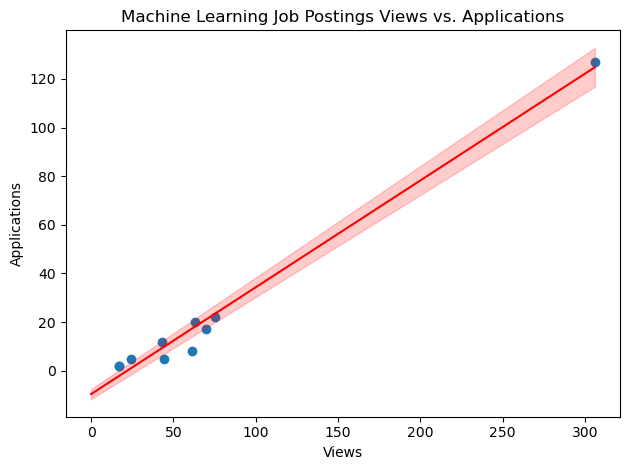

In [101]:
plt.figure()

views = ml_df['views'].to_numpy()
applies = ml_df['applies'].to_numpy()

plt.scatter(views, applies)

regression_results = linregress(views, applies) #linear regression between views and applications

#plot the line of best fit
x_plot = np.array([0, np.max(views)])
y_plot = regression_results.slope*x_plot + regression_results.intercept
plt.plot(x_plot, y_plot, marker='', ls='-', color='r')

#plot area of error
y_upper = (regression_results.slope + regression_results.stderr)*x_plot + regression_results.intercept + regression_results.intercept_stderr
y_lower = (regression_results.slope - regression_results.stderr)*x_plot + regression_results.intercept - regression_results.intercept_stderr
plt.fill_between(x_plot, y_lower, y_upper, color='r', alpha=0.2)


plt.xlabel("Views")
plt.ylabel("Applications")
plt.title("Machine Learning Job Postings Views vs. Applications")
plt.tight_layout()
plt.show()

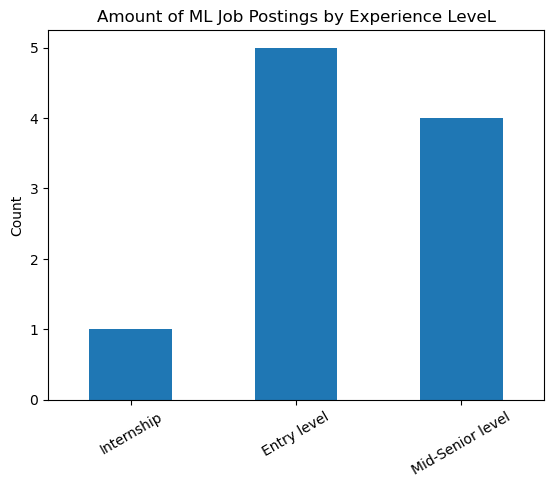

In [102]:
ml_df.formatted_experience_level.value_counts()[["Internship", "Entry level", "Mid-Senior level"]].plot(kind='bar', 
                                                                                                        xlabel="", 
                                                                                                        ylabel="Count",
                                                                                                        title="Amount of ML Job Postings by Experience LeveL")
plt.xticks(rotation=30)
plt.show()

<Figure size 640x480 with 0 Axes>

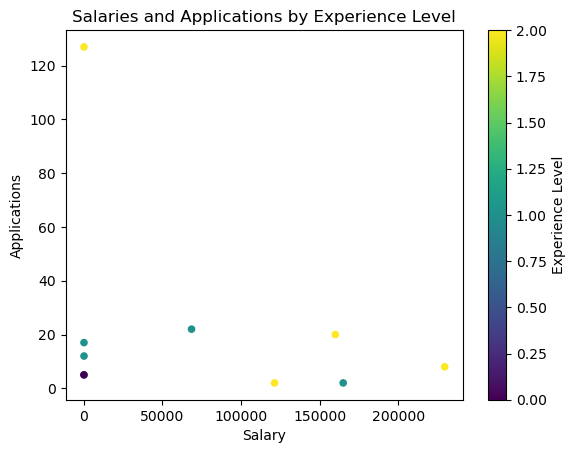

In [114]:
plt.figure()

ax = ml_df.plot.scatter("med_salary", "applies", c="experience_level_encoded",
                   colormap='viridis')
f = plt.gcf()
ax = f.get_axes()[1]
ax.set_ylabel("Experience Level"
              )
plt.xlabel("Salary")
plt.ylabel("Applications")
plt.title("Salaries and Applications by Experience Level")
plt.show()

In [ ]:
ml_df.formatted_experience_level.value_counts()[["Internship", "Entry level", "Mid-Senior level"]].plot(kind='bar', 
                                                                                                        xlabel="", 
                                                                                                        ylabel="Count",
                                                                                                        title="Amount of ML Job Postings by Experience LeveL")
plt.xticks(rotation=30)
plt.show()

In [30]:
ml_responses.objects[0].properties

{'description': "Dice is the leading career destination for tech experts at every stage of their careers. Our client, General Motors, is seeking the following. Apply via Dice today!\n\nDescription\n\n Job description summary: \n\nAs a member of the Plant Floor Execution and Quality Management IT organization, you will be responsible for leading teams that develop and deliver the software that powers GM Manufacturing. You will work with hands-on writing software or solutions based on detailed requirements and system specifications. You will work closely with products, business partners, operations, and analytics teams to understand how value can be delivered to the customers and operators using our software. We're looking for talented, motivated, and detail-oriented technologists with a passion for building robust systems at scale. Proficiency in front end and backend development strategies as well as automation.\n\n Full lifecycle application development using standard design patterns/